In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


print("Shape of train_images : ",train_images.shape)
print("Shape of train_labels : ",train_labels.shape)
print("Shape of test_images : ",test_images.shape)
print("Shape of test_labels : ",test_labels.shape)

Shape of train_images :  (50000, 32, 32, 3)
Shape of train_labels :  (50000, 1)
Shape of test_images :  (10000, 32, 32, 3)
Shape of test_labels :  (10000, 1)


In [3]:
# Selecting subset of three classes (0,1,2) from train and test data
train_index_list = []
test_index_list = []
for i in range(train_labels.shape[0]):
    if(train_labels[i,0] in [0,1,2]):
        train_index_list.append(i)
        
for i in range(test_labels.shape[0]):
    if(test_labels[i,0] in [0,1,2]):
        test_index_list.append(i)
        
subset_train_images = []
subset_train_labels = []
subset_test_images = []
subset_test_labels = []

for i in train_index_list:
    subset_train_images.append(train_images[i])
    subset_train_labels.append(train_labels[i,0])

for i in test_index_list:
    subset_test_images.append(test_images[i])
    subset_test_labels.append(test_labels[i,0])  

In [4]:
subset_train_images = np.array(subset_train_images)
subset_train_labels = np.array(subset_train_labels)
subset_test_images = np.array(subset_test_images)
subset_test_labels = np.array(subset_test_labels)

# train and validation split
final_train_images = subset_train_images[:13000]
final_train_labels = subset_train_labels[:13000]

final_validation_images = subset_train_images[13000:]
final_validation_labels = subset_train_labels[13000:]

print("Shape of subset train_images : ",final_train_images.shape)
print("Shape of subset train_labels : ",final_train_labels.shape)
print("Shape of subset validation_images : ",final_validation_images.shape)
print("Shape of subset validation_labels : ",final_validation_labels.shape)
print("Shape of subset test_images : ",subset_test_images.shape)
print("Shape of subset test_labels : ",subset_test_labels.shape)

Shape of subset train_images :  (13000, 32, 32, 3)
Shape of subset train_labels :  (13000,)
Shape of subset validation_images :  (2000, 32, 32, 3)
Shape of subset validation_labels :  (2000,)
Shape of subset test_images :  (3000, 32, 32, 3)
Shape of subset test_labels :  (3000,)


In [5]:
# Convert labels to categorical
train_labels_categorical = to_categorical(final_train_labels)
validation_labels_categorical = to_categorical(final_validation_labels)
test_labels_categorical = to_categorical(subset_test_labels)

# Vectorize the images
train_images = final_train_images.reshape((13000, 32* 32*3))
train_images = train_images.astype('float32') / 255
validation_images = final_validation_images.reshape((2000, 32*32*3))
validation_images = validation_images.astype('float32') / 255
test_images = subset_test_images.reshape((3000, 32*32*3))
test_images = test_images.astype('float32') / 255

In [6]:
# This class includes y = W0+W1*X1+W2*X2
class LinearLayer:
    """
        This Class implements all functions to be executed by a linear layer
        in a computational graph
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
                      Opitons are: plain, xavier and he
        Methods:
            forward(A_prev)
            backward(upstream_grad)
            update_params(learning_rate)
    """

    def __init__(self, input_shape, n_out):
        """
        The constructor of the LinearLayer takes the following parameters
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
        """

        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = {'W': np.random.randn(input_shape[1], n_out), 'b': np.random.randn(n_out)}  # initialize weights and bias
        self.Z = np.zeros((input_shape[0], n_out))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        This function performs the forwards propagation using activations from previous layer
        Args:
            A_prev:  Activations/Input Data coming into the layer from previous layer
        """

        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot( self.A_prev, self.params['W']) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        This function performs the back propagation using upstream gradients
        Args:
            upstream_grad: gradient coming in from the upper layer to couple with local gradient
        """

        # derivative of Cost w.r.t W
        self.dW = np.dot(self.A_prev.T, upstream_grad)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=0, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(upstream_grad, self.params['W'].T)

    def update_params(self, learning_rate=0.1):
        """
        This function performs the gradient descent update
        Args:
            learning_rate: learning rate hyper-param for gradient descent, default 0.1
        """

        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)
    

In [7]:
class SigmoidLayer:
    """
    This file implements activation layers
    inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [8]:
class SoftmaxLayer:
    """
    This file implements activation layers
    inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = np.exp(Z) / np.sum(np.exp(Z), axis=1)[:, None]  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [9]:
def compute_cost(Y, Y_hat):
    """
    This function computes and returns the Cost and its derivative.
    The is function uses the categorical cross-entropy loss ->
    Args:
        Y: labels of data
        Y_hat: Predictions(activations) from a last layer, the output layer
    Returns:
        cost: Binary cross-entropy loss
        dY_hat: gradient of Cost w.r.t the Y_hat
    """
    # Adding small number to avoid zero value in log function
    epsilon = 10**-8
    m = Y.shape[0]
    cost = 0
    # Adding epsilon = 1e^-8 to Y_hat
    Y_hat = Y_hat+epsilon
    
    # Categorical cross-entropy
    for true_arr, pred_arr in zip(Y, Y_hat):
        for true,pred in zip(true_arr, pred_arr):
            cost += (-true * np.log(pred+epsilon) )
    cost = (np.squeeze(cost)/m)  # remove extraneous dimensions to give just a scalar

    dY_hat = 0
    for true_arr, pred_arr in zip(Y, Y_hat):
        for true,pred in zip(true_arr, pred_arr):
            dY_hat += (-(true/(true-pred+epsilon)))
    dY_hat = -np.squeeze(dY_hat)/m
    
    # Gradient clipping for exploding gradient
    while(dY_hat > 10 or dY_hat < -10):
        dY_hat /= 10

    return cost, dY_hat

In [10]:
# Evaluation function : accuracy
def accuracy(Y, Y_hat):
    m = Y.shape[0]
    true_pred_count = 0
    for true,pred in zip(np.argmax(Y,axis=1), np.argmax(Y_hat,axis=1)):
        if(true == pred):
            true_pred_count += 1
    return (true_pred_count/m)        

#### Design the network with two hidden layers and 1 output layer :

In [11]:
# Our network architecture has the shape: 
#                   (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid] --> [Linear->Softmax] -->(output)  

#------ LAYER-1 ----- define 1st hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=train_images.shape, n_out=100)
A1 = SigmoidLayer(Z1.Z.shape)

#------ LAYER-2 ----- define 2nd hidden layer that take its values from hidden layer
Z2= LinearLayer(input_shape=A1.A.shape, n_out=100)
A2= SigmoidLayer(Z2.Z.shape)

#------ LAYER-3 ----- define output layer that take its values from hidden layer
Z3= LinearLayer(input_shape=A2.A.shape, n_out=3)
A3= SoftmaxLayer(Z3.Z.shape)

In [12]:
# define training constants
learning_rate = 0.000001
number_of_epochs = 201

train_loss = []# initially empty list, this will store all the costs after a certian number of epochs
train_accuracy = []
val_loss = []
val_accuracy = []

# Start training
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-pass -------------------------
    Z1.forward(train_images)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)    
    
    # ---------------------- Compute Cost ----------------------------
    cost, dA3 = compute_cost(Y=train_labels_categorical, Y_hat=A3.A)
    # Train accuracy
    acc = accuracy(train_labels_categorical, A3.A)
    #print(dA3)
    
    # ------------------------- backward-pass ----------------------------
    A3.backward(dA3)

    Z3.backward(A3.dZ)
    
    A2.backward(Z3.dA_prev)

    Z2.backward(A2.dZ)

    A1.backward(Z2.dA_prev)

    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z3.update_params(learning_rate=learning_rate)
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)
    
    # Validation data
    # ------------------------- forward-pass -------------------------
    Z1.forward(validation_images)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)    
    
    # ---------------------- Compute Cost ----------------------------
    val_cost, dA3 = compute_cost(Y=validation_labels_categorical, Y_hat=A3.A)
    # Validation accuracy
    val_acc = accuracy(validation_labels_categorical, A3.A)    
    

    # print and store Costs every 10 iterations.
    if (epoch % 10) == 0:
        #print("Cost at epoch#" + str(epoch) + ": " + str(cost))
        
        
        print("Epoch#{0}: Train_loss = {1:.5f}; Train_accuracy = {2:.5f}; Val_loss = {3:.5f}; Val_accuracy = {4:.5f}".format(epoch, cost,acc,val_cost,val_acc))
        #print(dA3)
        
        #print(A3.A[0:10])
        train_loss.append(cost)
        train_accuracy.append(acc)
        val_loss.append(val_cost)
        val_accuracy.append(val_acc)

Epoch#0: Train_loss = 6.10271; Train_accuracy = 0.33077; Val_loss = 5.88716; Val_accuracy = 0.33450
Epoch#10: Train_loss = 5.58636; Train_accuracy = 0.33077; Val_loss = 5.42198; Val_accuracy = 0.33400
Epoch#20: Train_loss = 5.22321; Train_accuracy = 0.33108; Val_loss = 5.08653; Val_accuracy = 0.33350
Epoch#30: Train_loss = 4.92776; Train_accuracy = 0.33131; Val_loss = 4.81094; Val_accuracy = 0.33300
Epoch#40: Train_loss = 4.67200; Train_accuracy = 0.33138; Val_loss = 4.57054; Val_accuracy = 0.33100
Epoch#50: Train_loss = 4.44562; Train_accuracy = 0.33123; Val_loss = 4.35621; Val_accuracy = 0.33050
Epoch#60: Train_loss = 4.24455; Train_accuracy = 0.33138; Val_loss = 4.16456; Val_accuracy = 0.32900
Epoch#70: Train_loss = 4.06634; Train_accuracy = 0.33231; Val_loss = 3.99362; Val_accuracy = 0.32950
Epoch#80: Train_loss = 3.77582; Train_accuracy = 0.33477; Val_loss = 3.59784; Val_accuracy = 0.33100
Epoch#90: Train_loss = 2.96290; Train_accuracy = 0.34600; Val_loss = 2.87262; Val_accuracy =

#### Plot the training and validation loss as a function of epochs. Plot the training and validation accuracy as a function of epochs

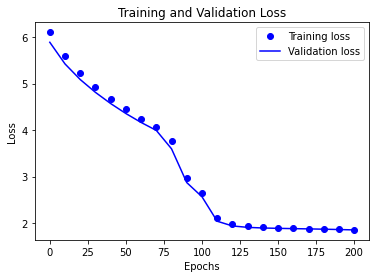

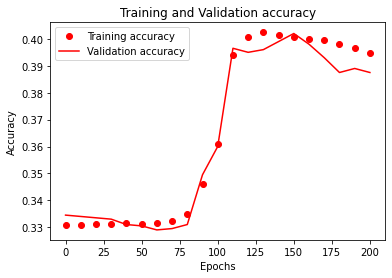

In [14]:
import matplotlib.pyplot as plt

epochs = range(0, 201, 10)

# Plot loss plot 
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy plot 
plt.plot(epochs, train_accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluating on the test data :

In [15]:
# Making predictions on test data
# ------------------------- forward-pass -------------------------
Z1.forward(test_images)
A1.forward(Z1.Z)
    
Z2.forward(A1.A)
A2.forward(Z2.Z)
    
Z3.forward(A2.A)
A3.forward(Z3.Z)

In [16]:
print("Test Accuracy : ",accuracy(test_labels_categorical, A3.A)*100)

Test Accuracy :  38.4


In [18]:
print("Test Loss : ",compute_cost(test_labels_categorical, A3.A)[0])

Test Loss :  1.8777535310570248
